In [1]:
%cd ..

d:\Projects\vislang\vis_lang


In [2]:
from cifar10_emb import Cifar10Emb
import torch

In [15]:
variant = Cifar10Emb(root_path='.')

variant.dataloader_args['batch_size'] = 1

variant.init_datasets()
variant.init_dataloaders()
variant.set_up_model_architecture(300)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
variant.init_word_lookup()

In [16]:
state = torch.load('./trained_models/vis_lang/cifar10_emb_missing_cat.pth')
variant.model.load_state_dict(state['net'])

<All keys matched successfully>

In [18]:
import matplotlib.pyplot as plt

for img, label in variant.test_loader:
    img = img.cuda()

    if label 

    embedding = variant.model(img)
    break

In [19]:
embedding

tensor([[ 9.8305e-02,  3.4001e-02, -1.5406e-01,  2.0952e-02, -1.9681e-02,
         -1.0060e-01, -2.8397e-02, -4.7486e-02,  1.9349e-01, -2.0366e-02,
          1.3624e-01, -2.5692e-01,  4.0705e-03, -2.1831e-01, -3.9589e-02,
          3.3224e-02, -8.2038e-02,  7.1644e-02, -1.9845e-02, -7.8471e-02,
          1.6090e-02, -6.9732e-02,  3.5089e-02,  1.1005e-02, -1.6012e-02,
          4.2657e-02, -1.0698e-01,  1.6843e-01,  2.0501e-01, -3.8842e-02,
         -1.5030e-01, -3.9442e-02, -4.8102e-02, -1.4901e-02, -3.5230e-02,
          2.9118e-02,  8.6148e-02,  2.5635e-02,  7.0476e-02,  1.5127e-01,
          3.5153e-02,  7.3389e-03,  1.2948e-01,  7.8969e-02, -8.5982e-02,
         -1.6924e-01,  6.0772e-02,  5.4012e-02,  1.6905e-01,  9.6901e-02,
         -1.3365e-01,  4.9780e-02,  1.5552e-01,  2.7485e-03, -2.3428e-02,
         -8.8211e-03,  9.7266e-02, -6.7825e-02,  1.8745e-01,  1.1143e-02,
          1.2661e-01, -4.0707e-02, -9.5472e-02, -5.2246e-02,  1.9496e-02,
         -7.8181e-02, -2.0007e-02, -1.

In [37]:
from base import get_device
def eval_acc(self):
    """ Returns the per-class accuracy evaluated on the validation set. """
    self.model.eval()

    totals  = [0] * len(self.class_names)
    correct = [0] * len(self.class_names)

    with torch.no_grad():
        for inputs, labels in self.test_loader:
            device = get_device()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = self.model(inputs)

            for idx, _class in enumerate(self.class_names):
                is_class = (labels == idx)

                cur_labels  = labels[is_class]
                if cur_labels.shape[0] == 0:
                    continue

                cur_outputs = outputs[is_class]

                totals[idx] += cur_labels.size(0)
                correct[idx] += self.num_correct_preds(cur_outputs, cur_labels)

    return [c * 100 / t for c, t in zip(correct, totals)]

In [39]:
eval_acc(variant)

[96.6, 97.8, 93.2, 0.0, 95.6, 95.7, 97.4, 95.2, 94.1, 95.7]

In [53]:
 cats = []
 for inputs, labels in variant.test_loader:
    if variant.class_names[labels[0]] == 'cat':
        cats.append(inputs[0])
        if len(cats) > 100:
            break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


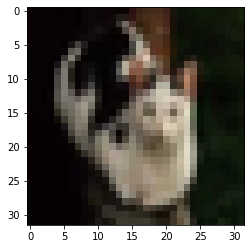

In [54]:
img = cats[2]

img_numpy = img.permute(1, 2, 0).contiguous().numpy()
img_numpy = img_numpy * (0.2023, 0.1994, 0.2010) + (0.4914, 0.4822, 0.4465)

plt.imshow(img_numpy)

In [57]:
embedding = variant.model(img[None, ...].cuda())

In [63]:
lookup = variant.model.word_lookup

l2_dist = ((lookup[:, :] - embedding) ** 2).sum(-1)

In [64]:
l2_dist

tensor([14.1695, 14.1091,  9.6295,  4.1504, 13.6843,  0.0168, 12.0130,  9.3185,
        14.1783, 12.4360], device='cuda:0', grad_fn=<SumBackward1>)

In [65]:
variant.class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [66]:
dog_l2_dist = ((lookup[:, :] - lookup[None, 5, :]) ** 2).sum(-1)

In [67]:
dog_l2_dist

tensor([14.8615, 14.7763, 10.2325,  4.3328, 14.4052,  0.0000, 12.5353,  9.6917,
        14.7291, 13.0752], device='cuda:0')

In [68]:
4.3328-4.1504

0.18239999999999945

In [71]:
dog_l2_dist * ~(dog_l2_dist == l2_dist)

tensor([14.8615, 14.7763, 10.2325,  4.3328, 14.4052,  0.0000, 12.5353,  9.6917,
        14.7291, 13.0752], device='cuda:0')